In [1]:
# key_diary = '1PvDofnCSTH5MH4vdU9J0fsaTjYzthPpmp4jgUvVU1Lc'

In [ ]:
### Connect using gspread

import gspread

gc = gspread.service_account(filename = 'Babysleep-tryout-client-secret.json')

# get the instance of the Spreadsheet
sheet = gc.open('Babysleep-diaries_18.01.21-19.02.21')

In [ ]:
# Returns a list of all worksheets in a spreadsheet.
print(sheet.worksheets())

# Returns a worksheet with specified title. The returning object is an instance of Worksheet.
#sht1 = sheet.worksheet('1. Рябцева Анна (Яна)')
#sht1

Import spreadsheet as a dataframe

In [135]:
import gspread_dataframe as gd

df = gd.get_as_dataframe(sheet_instance,evaluate_formulas = True,skiprows = 1, has_header = True)

#how many columns and rows?
print('shape of DataFrame: ', df.shape) #with NaN values in rows
print('row count of DataFrame:\n', df.count())

# import colunm names
# print(df.columns)

shape of DataFrame:  (967, 98)
row count of DataFrame:
 Дата рождения        367
Дата                 367
Мес.                 367
Дн.                  367
УТРО (проснулись)     52
                    ... 
НОЧЬ (уже спит)       51
ИТОГО дл-ть НС       367
ИТОГО СНА            367
Unnamed: 96            0
Unnamed: 97            0
Length: 98, dtype: int64


In [ ]:
# print one column
df[['ВРЕМЯ засыпания в НОЧЬ (пережолили / отпустил грудь / вышли из комнаты и т.п.)', 'Кол-во ночных проб-й']]

Визуализация:
у одного ребенка - время первого пробуждения каждый день, количество просыпаний каждый день
у всех детей - количество просыпаний каждый день, swarmplot / barplot после groupby по количеству просіпаний

In [6]:
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
# https://www.geeksforgeeks.org/args-kwargs-python/#:~:text=The%20special%20syntax%20**kwargs,and%20any%20number%20of%20them).

def pr_bold(*argv):
    for arg in argv:
        print('\033[1m',arg,'\033[0m',sep='', end=' ')

pr_bold('Hello', 'world')

Hello world 

Prepare the DataFrame with only data to be visualised:

1. select columns needed for visualisation in a separate DataFrame
2. check, if there are NaNs - is it normal?
3. delete NaNs
4. adjust data types: date, time, integers...

In [145]:
def create_df(df1, list1, list2):
    """ Creates a new DataFrame from an existing DataFrame df1.
    From df1 data from columns from list1 will be copied. The columns in the new DataFrame
    wil be called according to the list2. The order of the names must be the same 
    in list1 and list2.
    """
    df2 = pd.DataFrame()
    df2 = df1.loc[:, list1]
    dict_col = {}
    df2.columns = list2
    return df2

columns1 = ['Дата ', 'УТРО (проснулись)', 'ВРЕМЯ засыпания в НОЧЬ (пережолили / отпустил грудь / вышли из комнаты и т.п.)', 'Кол-во ночных проб-й']
columns2 = ['Date', 'First wake up time', 'Sleep starting time', 'Nr of night wake ups']
df_vis = create_df(df, columns1, columns2)
df_vis

,Date,First wake up time,Sleep starting time,Nr of night wake ups
0,18.01.21,6:50,20:10,4.0
1,19.01.21,7:57,20:25,4.0
2,20.01.21,8:00,20:35,4.0
3,21.01.21,7:28,20:05,4.0
4,22.01.21,7:52,19:50,3.0
...,...,...,...,...
962,NaN,NaN,NaN,NaN
963,NaN,NaN,NaN,NaN
964,NaN,NaN,NaN,NaN
965,NaN,NaN,NaN,NaN


In [156]:
# Analysis of NaN in the newly created DF

pr_bold('Shape after creation:')
print(df_vis.shape)
pr_bold('DataFrame for visualisation:\n')
print(df_vis.head())
pr_bold('\nNaNs in Data Frame?')
print(df_vis.isnull().values.any())
pr_bold('\nNaNs are in following columns:\n')
print(df_vis.isnull().sum())

df_vis.dropna(axis=0, how='any', inplace=True) #, subset=['Nr of night wake ups'])
pr_bold('\nShape after NaN extraction:')
print(df_vis.shape)
#pr_bold('DataFrame after NaN extraction:\n')
#print(df_vis.head())
pr_bold('\nAny NaN left?\n')
print(df_vis.isnull().any())
print()
df_vis['Nr of night wake ups'] = df_vis['Nr of night wake ups'].astype(int)
df_vis.info()

Shape after creation: (49, 4)
DataFrame for visualisation:
        Date First wake up time Sleep starting time  Nr of night wake ups
0  18.01.21               6:50               20:10                     4
1  19.01.21               7:57               20:25                     4
2  20.01.21               8:00               20:35                     4
3  21.01.21               7:28               20:05                     4
4  22.01.21               7:52               19:50                     3

NaNs in Data Frame? False

NaNs are in following columns:
 Date                    0
First wake up time      0
Sleep starting time     0
Nr of night wake ups    0
dtype: int64

Shape after NaN extraction: (49, 4)

Any NaN left?
 Date                    False
First wake up time      False
Sleep starting time     False
Nr of night wake ups    False
dtype: bool

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 50
Data columns (total 4 columns):
 #   Column                Non-Null C

In [94]:
# create a dictionary for renaming of columns

list1 = ['q', 'w', 'r', 't', 'z']
list2 = ['a', 's', 'd', 'f', 'g']
dict_col={}
for i in range(len(list1)):
    dict_col[list1[i]] = list2[i]
print(dict_col)

{'q': 'a', 'w': 's', 'r': 'd', 't': 'f', 'z': 'g'}


In [8]:
import time

# convert time into a timestamp with hours and minutes 
df_vis['First wake up time timestamp'] = pd.to_datetime(df_vis['First wake up time'], format='%H:%M').dt.time

# convert timestamp to a number
df_vis['First wake up time to int'] = [int(t.strftime('%H%M')) for t in df_vis['First wake up time timestamp']]

print(df_vis.info()) #.iloc[:,[0,1,3]])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 50
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          49 non-null     object
 1   First wake up time            49 non-null     object
 2   Sleep starting time           49 non-null     object
 3   Nr of night wake ups          49 non-null     int32 
 4   First wake up time timestamp  49 non-null     object
 5   First wake up time to int     49 non-null     int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 2.5+ KB
None


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


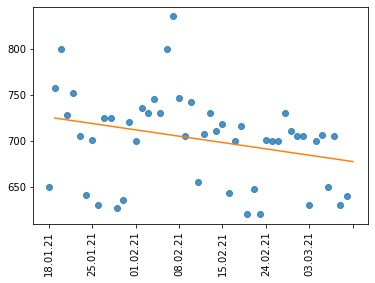

In [52]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

x = df_vis['Date']
y = df_vis['First wake up time to int']
x2 = np.arange(1, len(x)+1) # needed for linear regression

plt.plot(x,y,'o', alpha=0.8)
# rotate the x ticks and define their frequency
plt.xticks(np.arange(0, len(x)+1, 7), rotation = 90)

#labels = [str(t.hour) + ':' + str(t.minute) for t in df_vis['First wake up time timestamp']]
#plt.yticks(labels=labels)
m, b = np.polyfit(x2, y, 1)
# m = slope, b=intercept

plt.plot(x2, m*x2 + b)
plt.show()

[Text(0, 0, '18.01.21'),
 Text(0, 0, '23.01.21'),
 Text(0, 0, '28.01.21'),
 Text(0, 0, '02.02.21'),
 Text(0, 0, '07.02.21'),
 Text(0, 0, '12.02.21'),
 Text(0, 0, '17.02.21'),
 Text(0, 0, '24.02.21'),
 Text(0, 0, '01.03.21'),
 Text(0, 0, '06.03.21')]

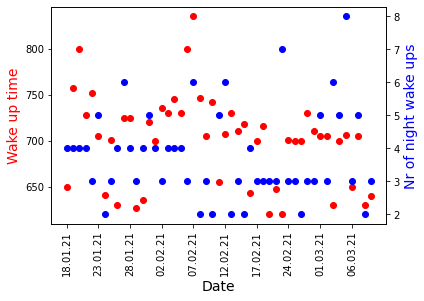

In [56]:
df_vis.sort_values('First wake up time to int')

fig, ax1 = plt.subplots(1,1)

ax1.scatter(df_vis['Date'], df_vis['First wake up time to int'], color='red')
labels = [str(t.hour) + ':' + str(t.minute) for t in df_vis['First wake up time timestamp']]

xlabels = list(df_vis['Date'][::5])
ax1.set_xticks(df_vis['Date'][::5])
ax1.set_xticklabels(xlabels, rotation=90)
#ax1.set_yticklabels(labels, minor=False, rotation=45)

#set x-axis label
ax1.set_xlabel('Date',fontsize=14)
# set y-axis label
ax1.set_ylabel('Wake up time', color='red',fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax1.twinx()

# make a plot with different y-axis using second axis object
ax2.scatter(df_vis['Date'], df_vis['Nr of night wake ups'],color='blue',marker="o")
ax2.set_ylabel('Nr of night wake ups',color='blue',fontsize=14)
ax2.set_xticks(df_vis['Date'][::5])
ax2.set_xticklabels(xlabels, rotation=90)

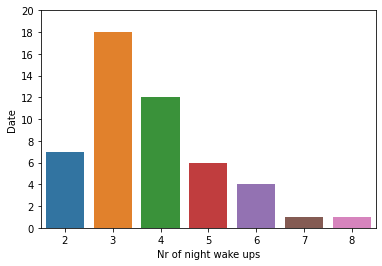

In [40]:
import seaborn as sns

gr_df_vis = df_vis.groupby('Nr of night wake ups', as_index=False).count()
#print(gr_df_vis.head())
sns.barplot(x='Nr of night wake ups', y='Date', data=gr_df_vis)
plt.yticks(np.arange(0, 21, 2))
plt.show()